# Plot decile charts of each measure for each group

In [9]:
from  ebmdatalab import charts
import pandas as pd
from os import listdir,path,environ
from measures import measures_kwargs,groups
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import itertools

In [3]:
first = True
for f,d in [(path.join('..','output','measures',f),f.replace('input_','').replace('.csv.gz','')) for f in listdir(path.join('..','output','measures')) if f.startswith('input')]:
    if first:
        df = pd.read_csv(f).assign(date=d)
        first=False
    else:
        df = pd.concat([df,pd.read_csv(f).assign(date=d)])
df.date = df.date= pd.to_datetime(df.date)

In [ ]:
if "practice" in groups:
    groups.remove("practice")
plots = []
for measure in measures_kwargs:
    df[measure["id"]] = df[measure["numerator"]] / df[measure["denominator"]]
    for group in groups:
        df_to_plot = (
            df.groupby(["practice", group, "date"])[[measure["numerator"], measure["denominator"]]]
            .sum()
            .reset_index()
        )
        df_to_plot[measure["id"]] = df_to_plot.apply(
            lambda x: x[measure["numerator"]] / x[measure["denominator"]]
            if x[measure["denominator"]] > 0
            else 0,
            axis=1,
        )

        if environ["OPENSAFELY_BACKEND"] == "expectations":
            df_to_plot[measure["id"]] = df_to_plot[measure["id"]].fillna(0)
            df_to_plot[measure["id"]] = df_to_plot.apply(
                lambda x: x[measure["id"]]
                if x[measure["id"]] <= 1
                else 1 / x[measure["id"]],
                axis=1,
            )

        group_values = df_to_plot[group].drop_duplicates()
        n_groups = len(group_values)
        fig = plt.figure(figsize=(12, 8 * n_groups))
        fig.autofmt_xdate()
        layout = gridspec.GridSpec(n_groups, 1, figure=fig)
        for groupval, lax in zip(group_values, layout):
            ax = plt.subplot(lax)
            charts.deciles_chart(
                df_to_plot[df_to_plot[group] == groupval],
                "date",
                measure["id"],
                f'{measure["id"].replace("_"," ").title()} - {group.title()}:{groupval}',
                ax=ax,
            )
        plots.append(fig)

In [17]:
infection_antibiotic_cols = {}
for a,b in itertools.product(['infection','antibiotic'],['date','code']):
    infection_antibiotic_cols[(a,b)] = sorted([c for c in df.columns if c.startswith(f'{a}_{b}_')])

In [31]:
date_cols = sorted([v for k,v in infection_antibiotic_cols.items() if k[1]=='date'])
for a_col in date_cols[0]:
    for i_col in date_cols[1]:
        df[f'{a_col}_match'] = df.apply(lambda x: 1 if (f'{a_col}_match' in df.columns and x[f'{a_col}_match']==1) or x[f'{a_col}']==x[f'{i_col}'] else 0,axis=1)
        df[f'{i_col}_match'] = df.apply(lambda x: 1 if (f'{i_col}_match' in df.columns and x[f'{i_col}_match']==1) or x[f'{a_col}']==x[f'{i_col}'] else 0,axis=1)

for x in ['infection','antibiotic']:
    df[f'{x}_match_count'] = df[[c for c in df.columns if c.endswith('_match') and c.startswith(x)]].aggregate(sum,axis=1)

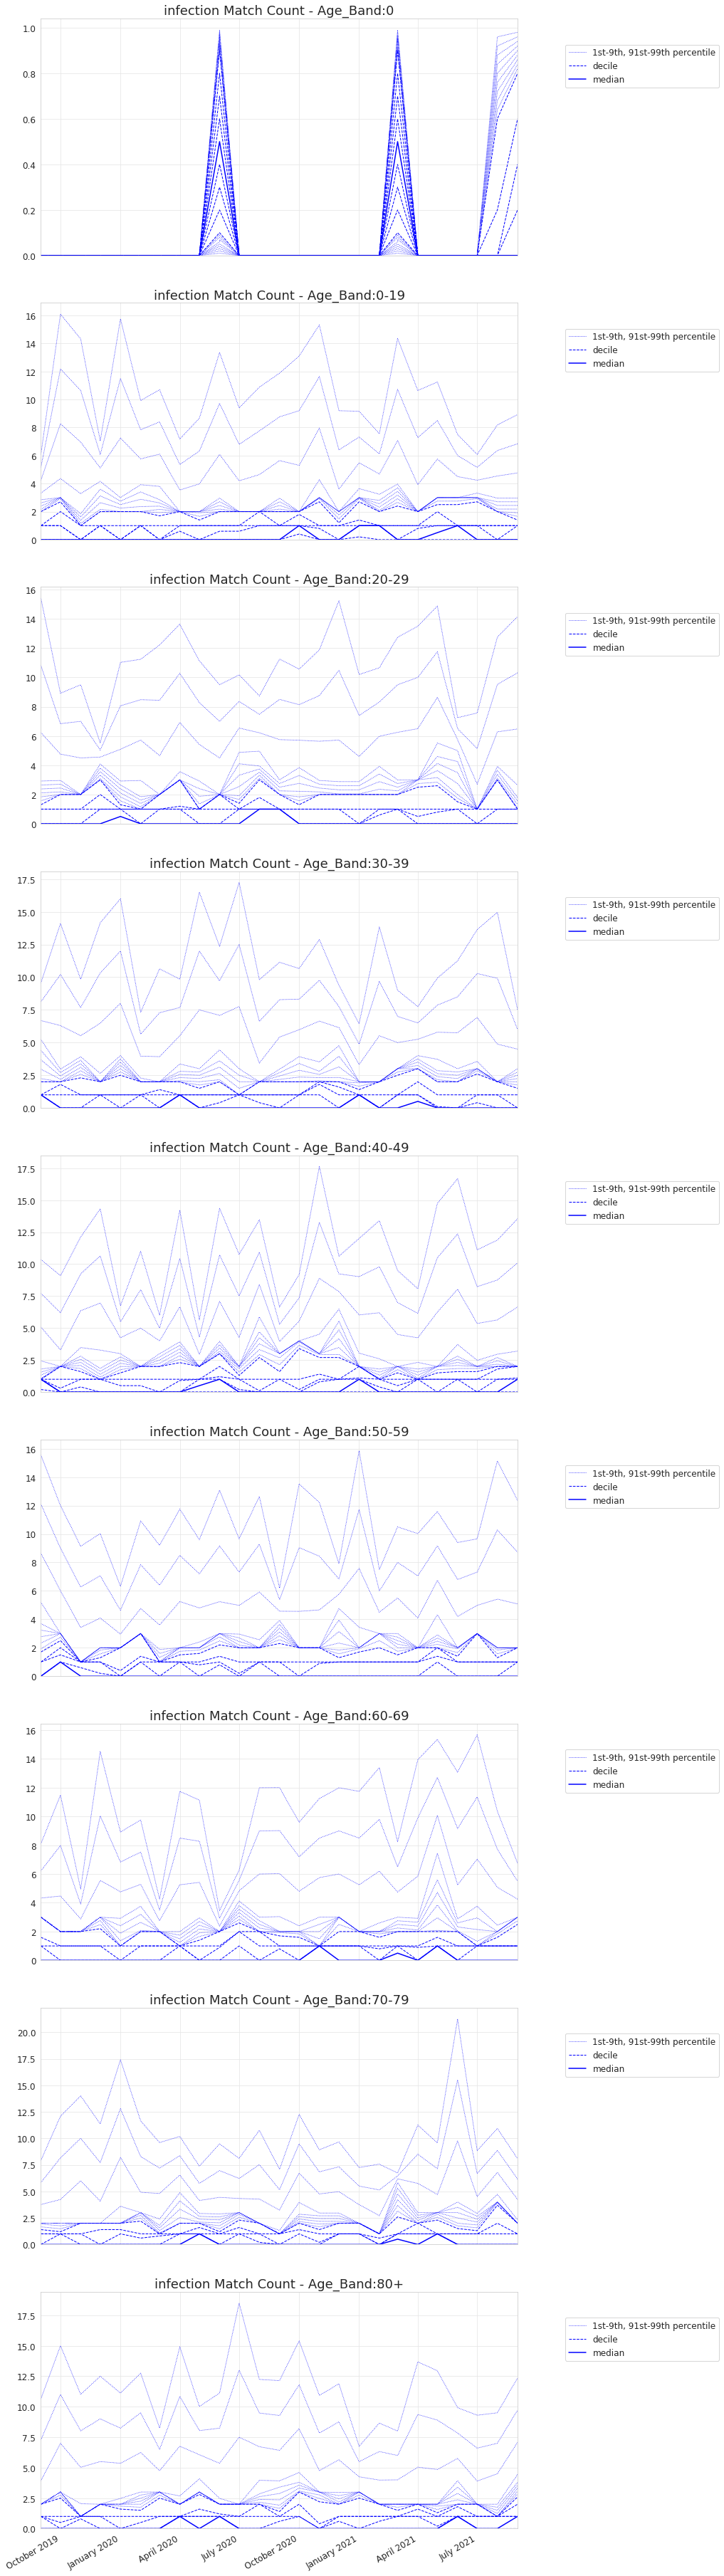

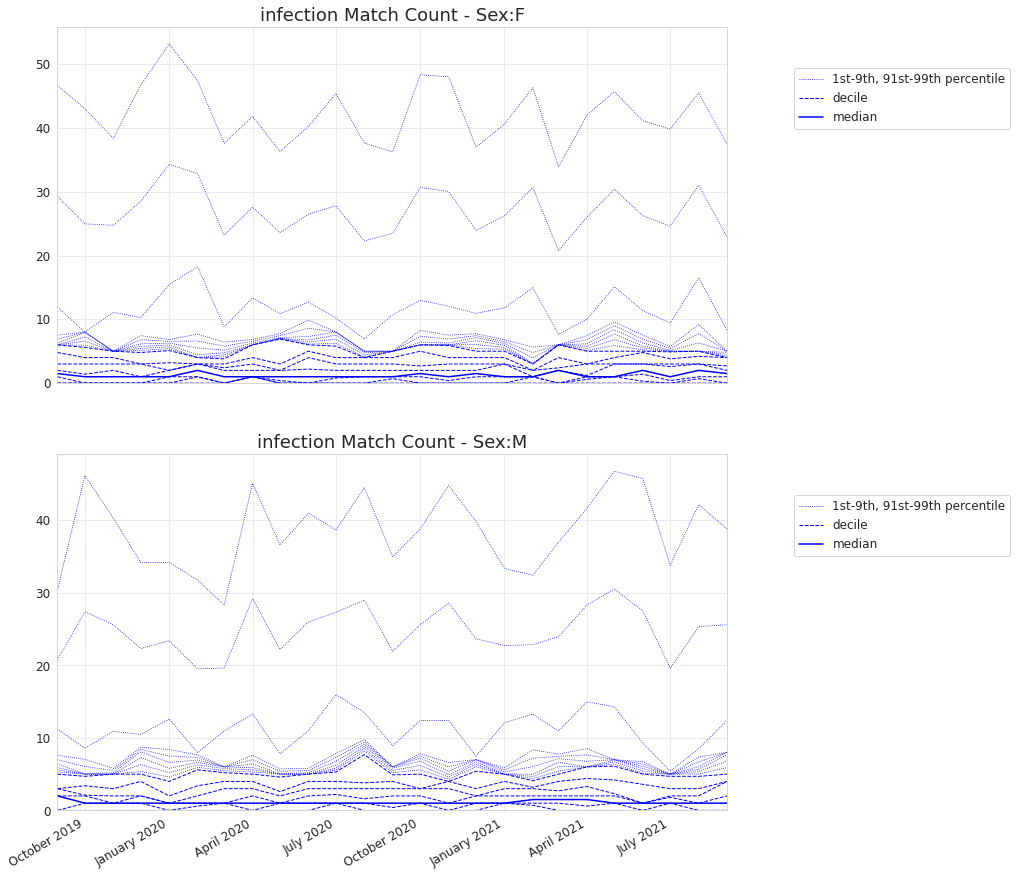

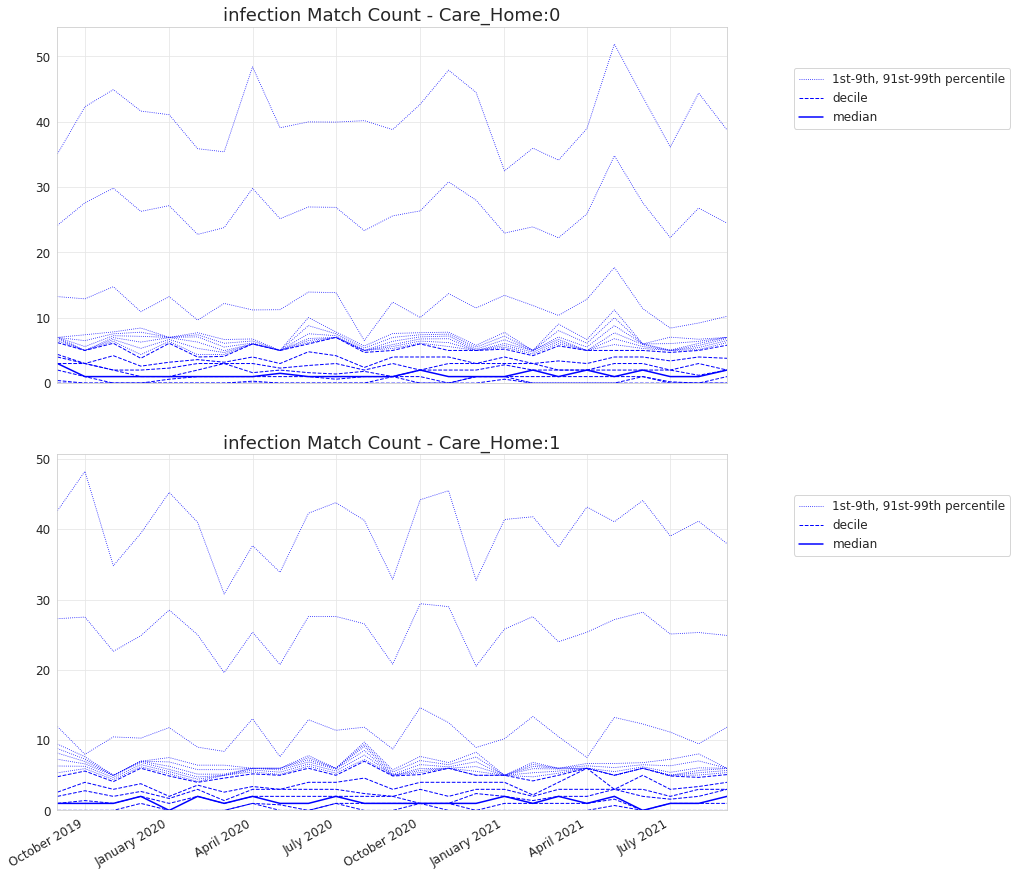

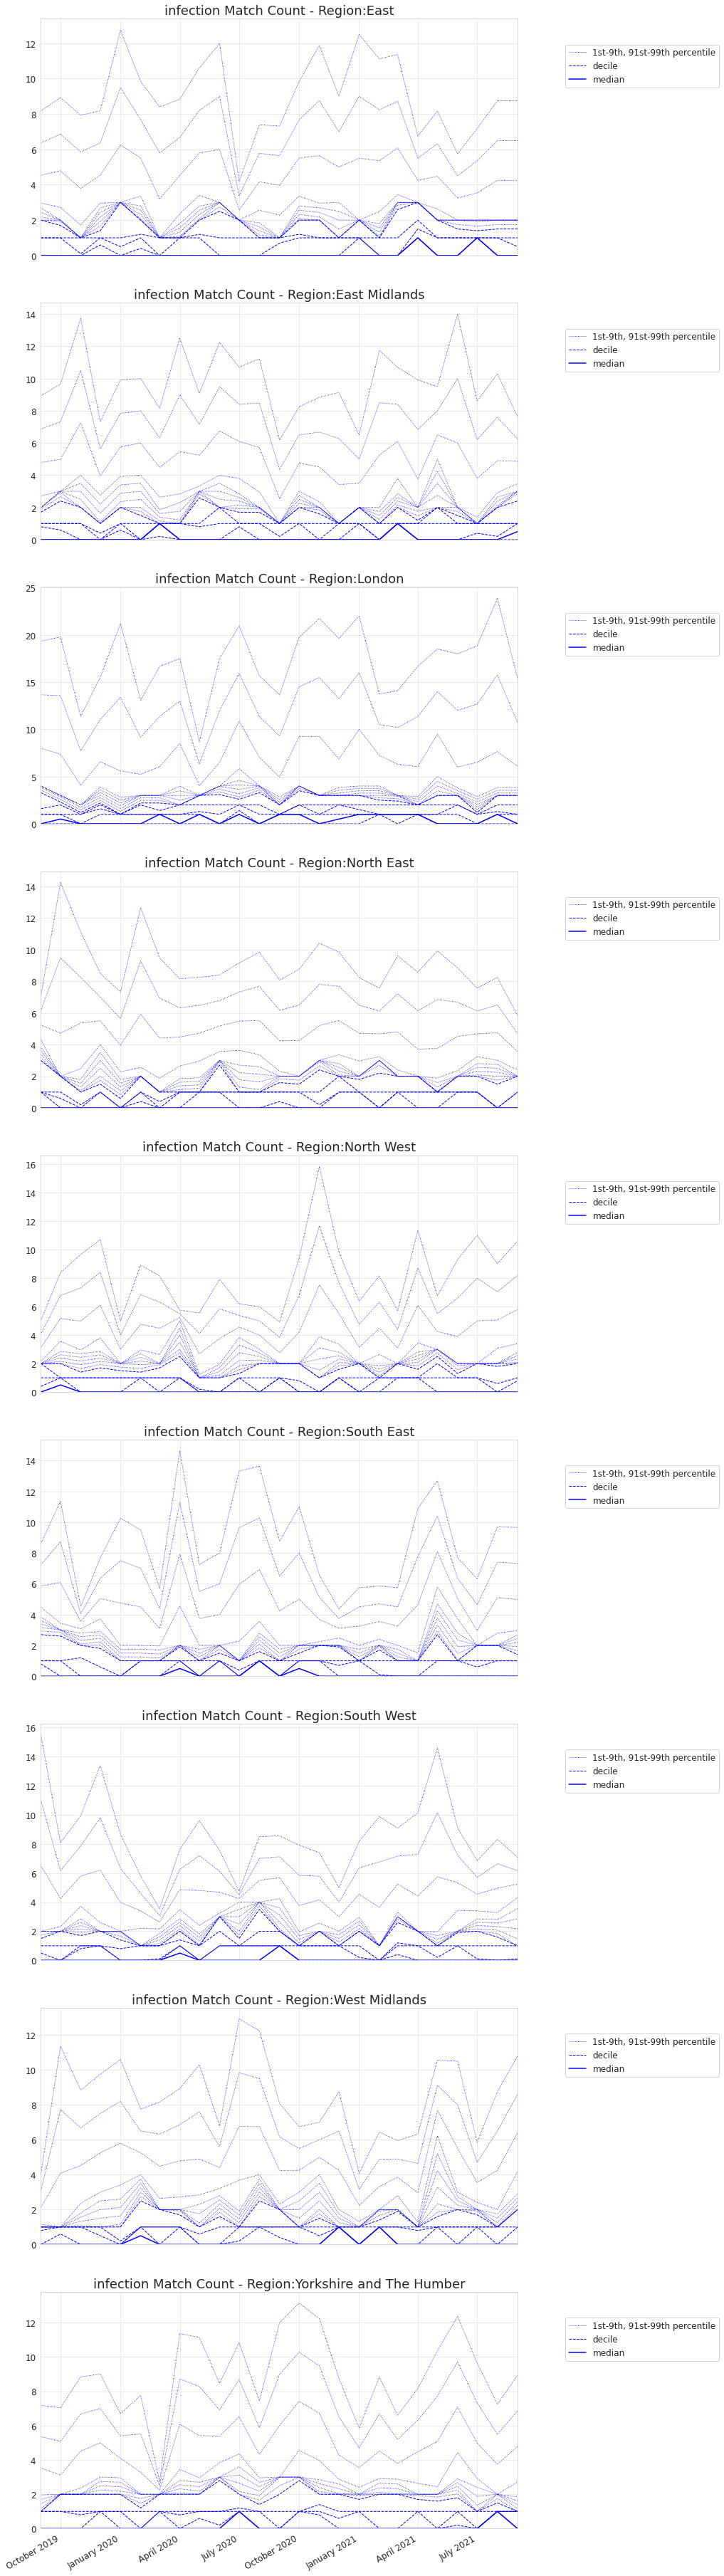

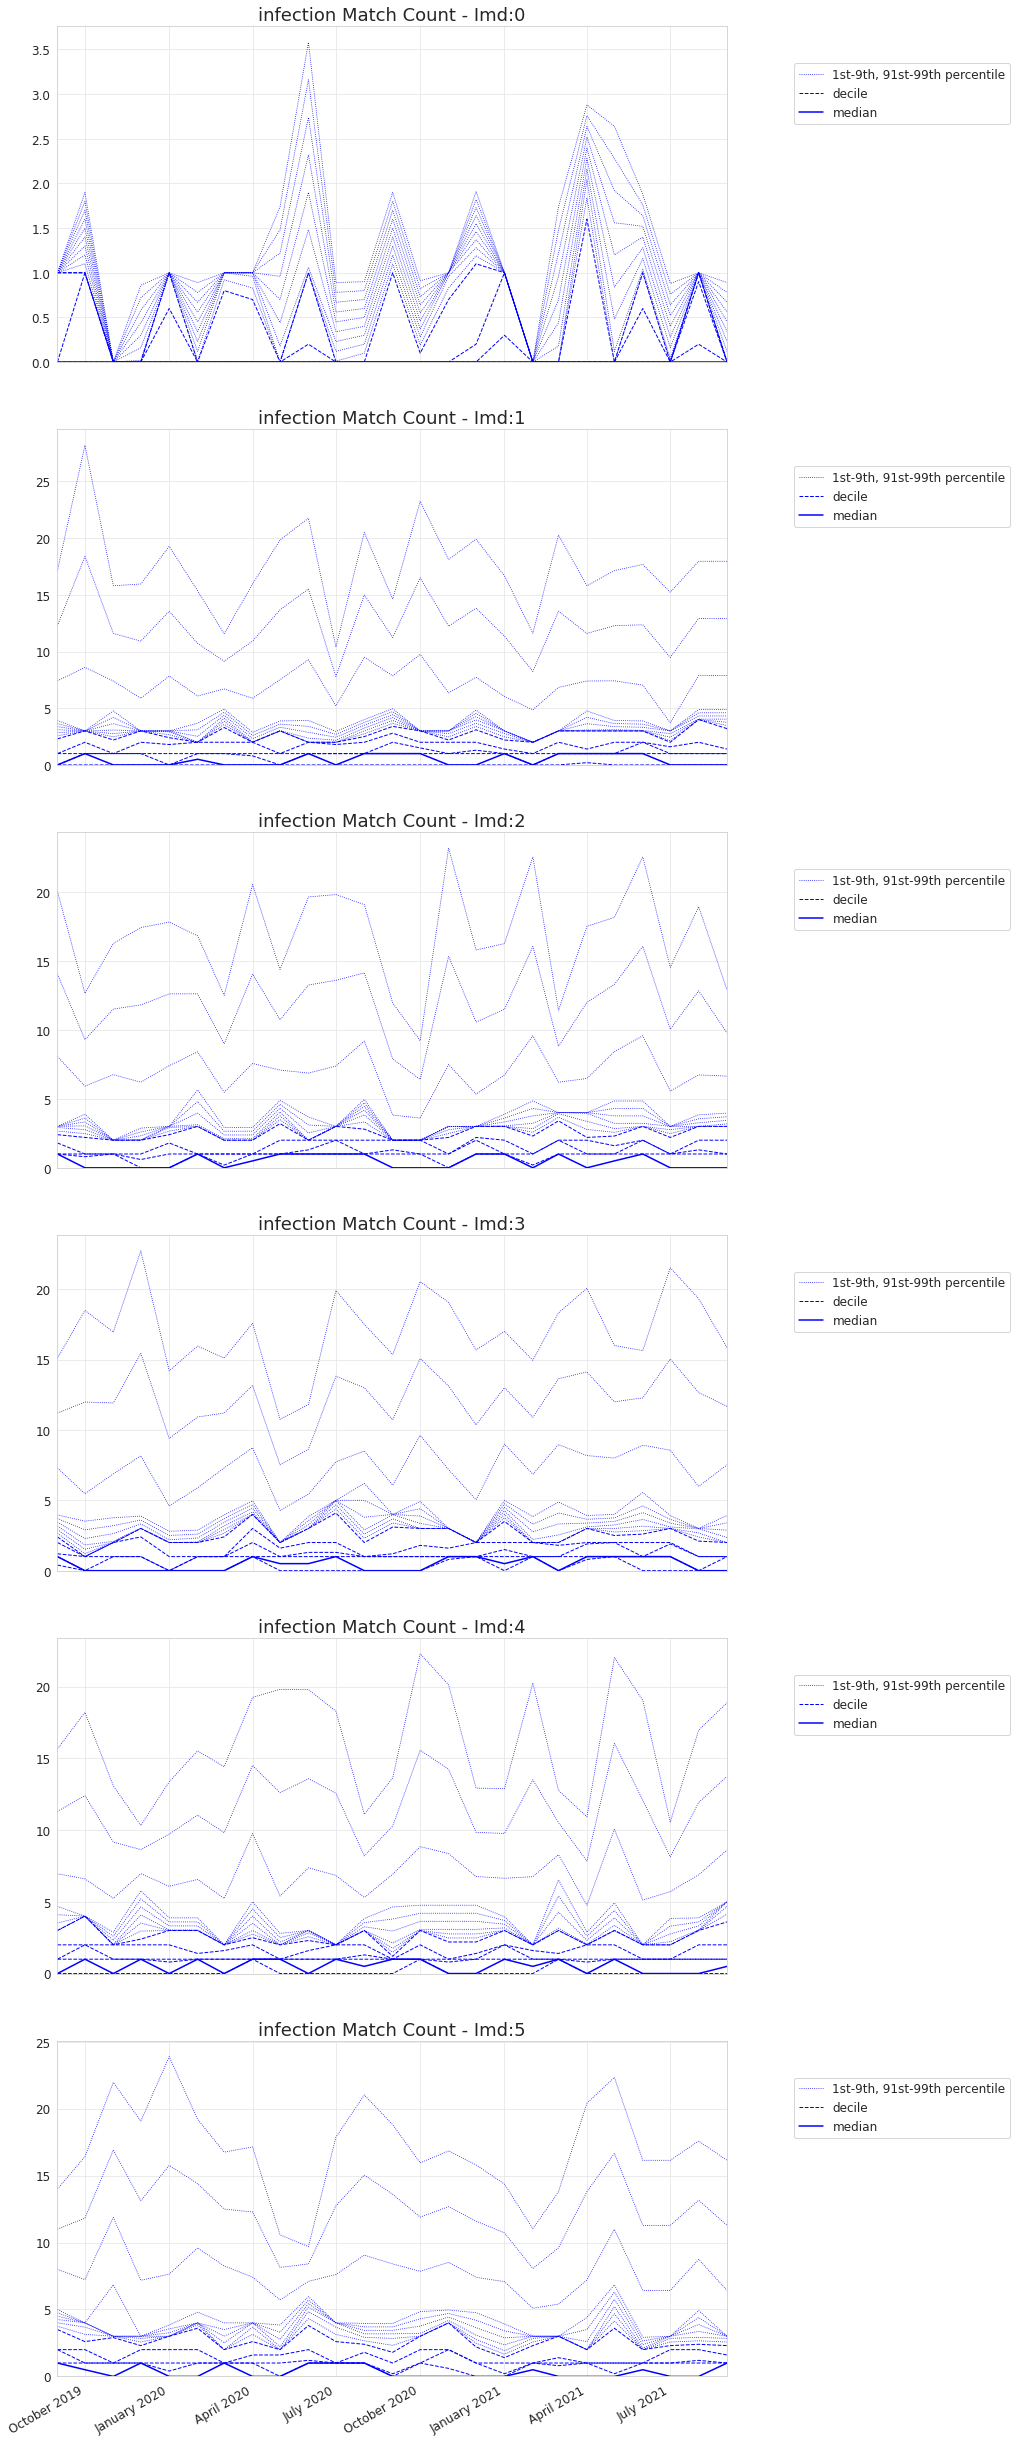

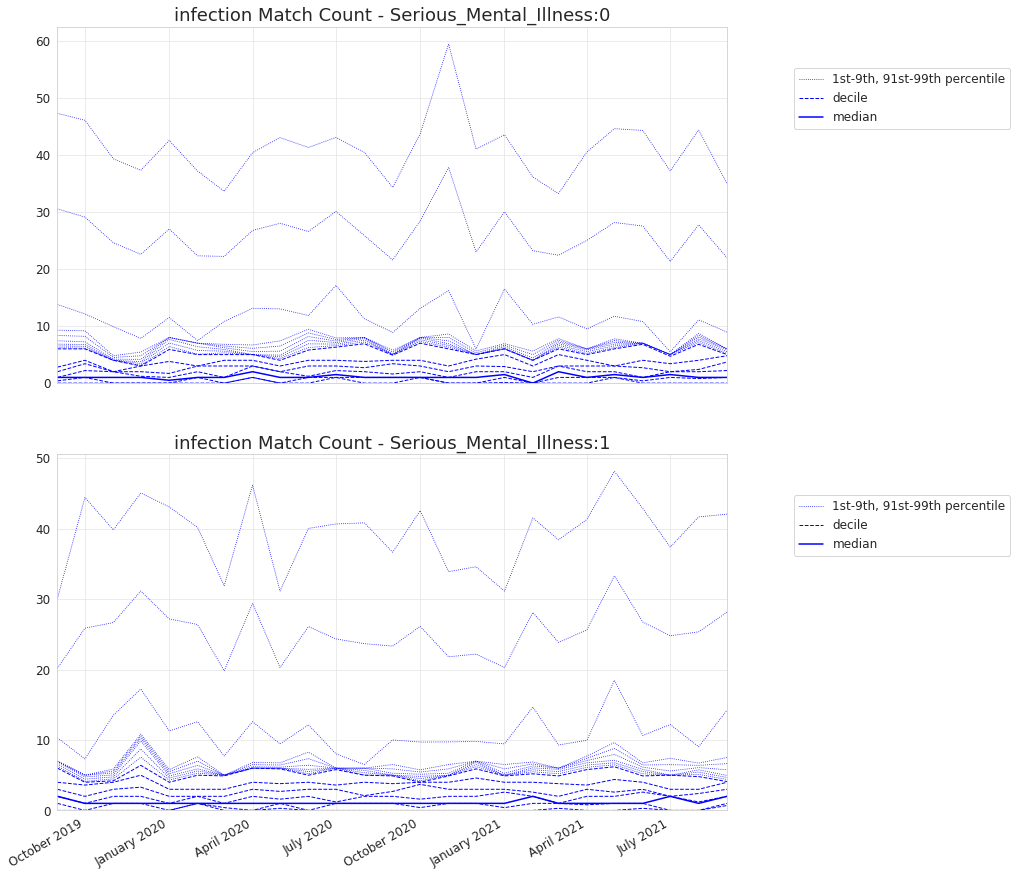

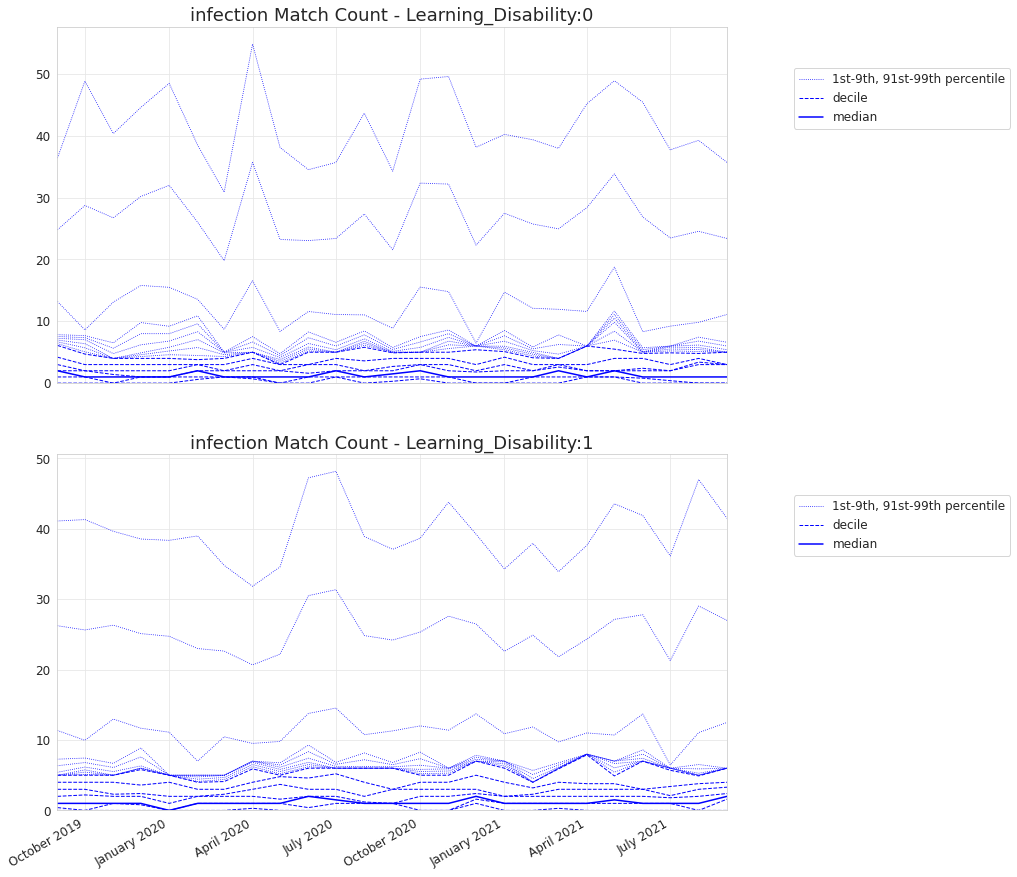

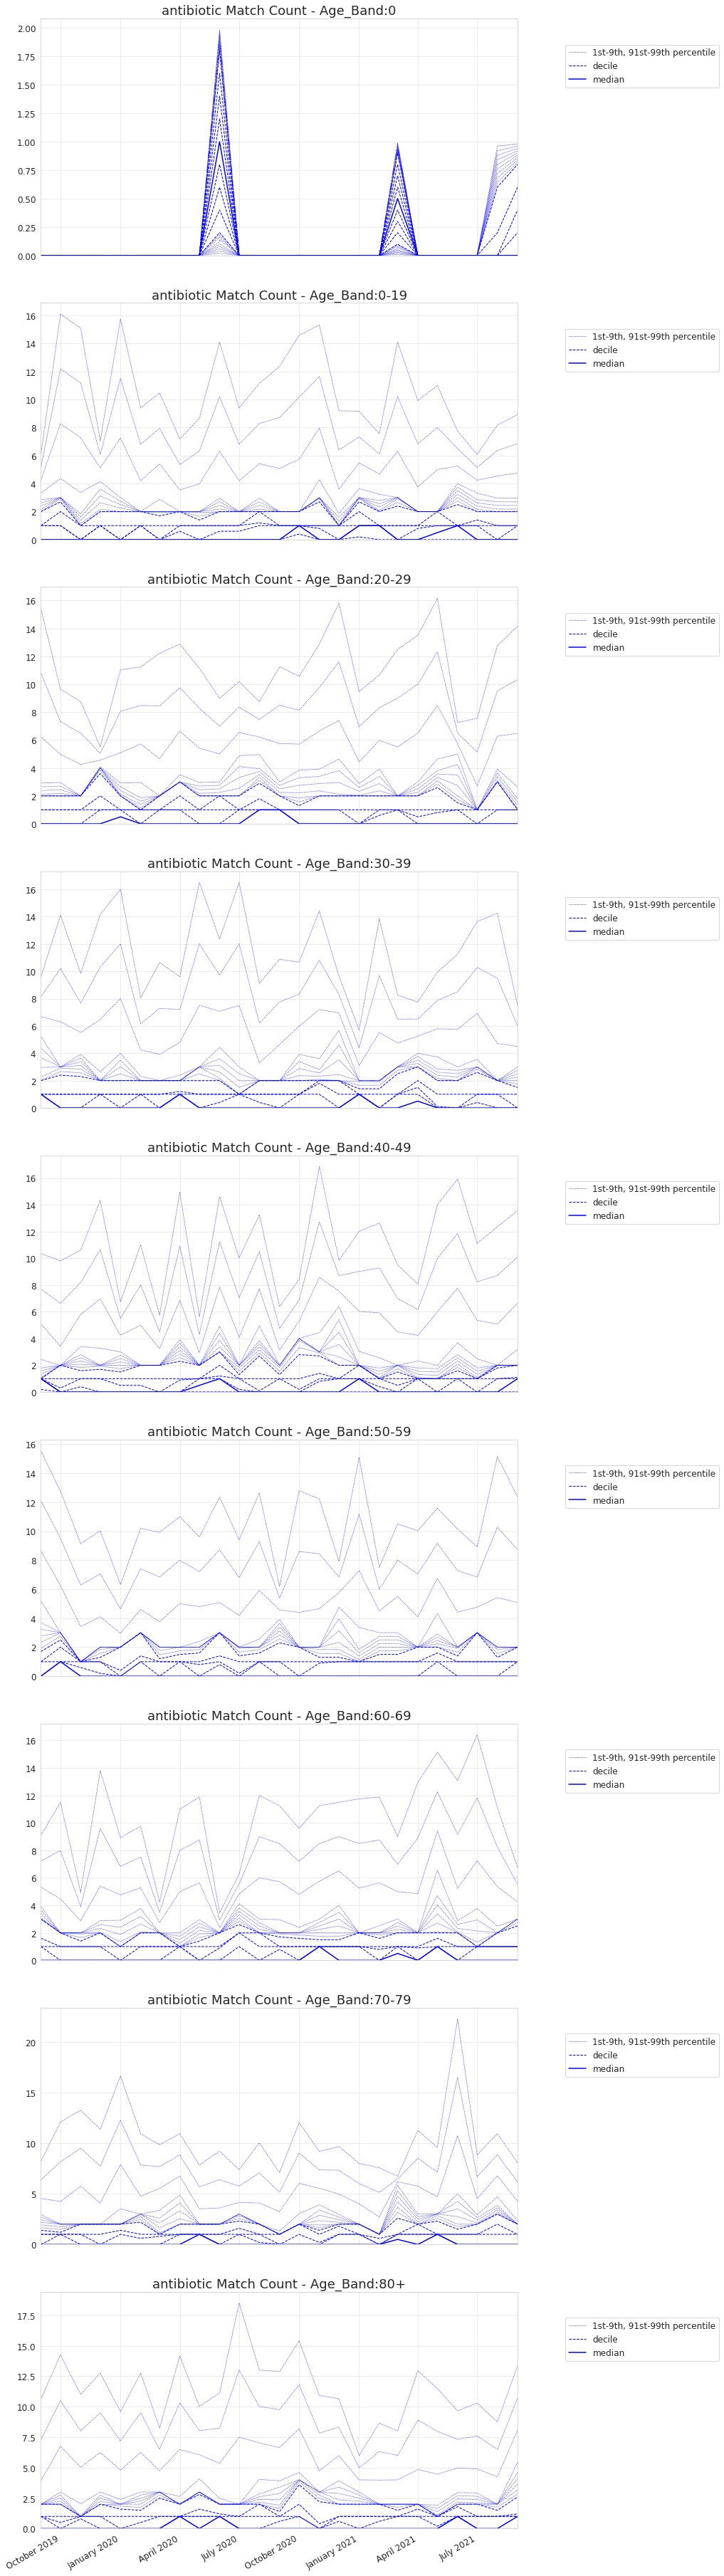

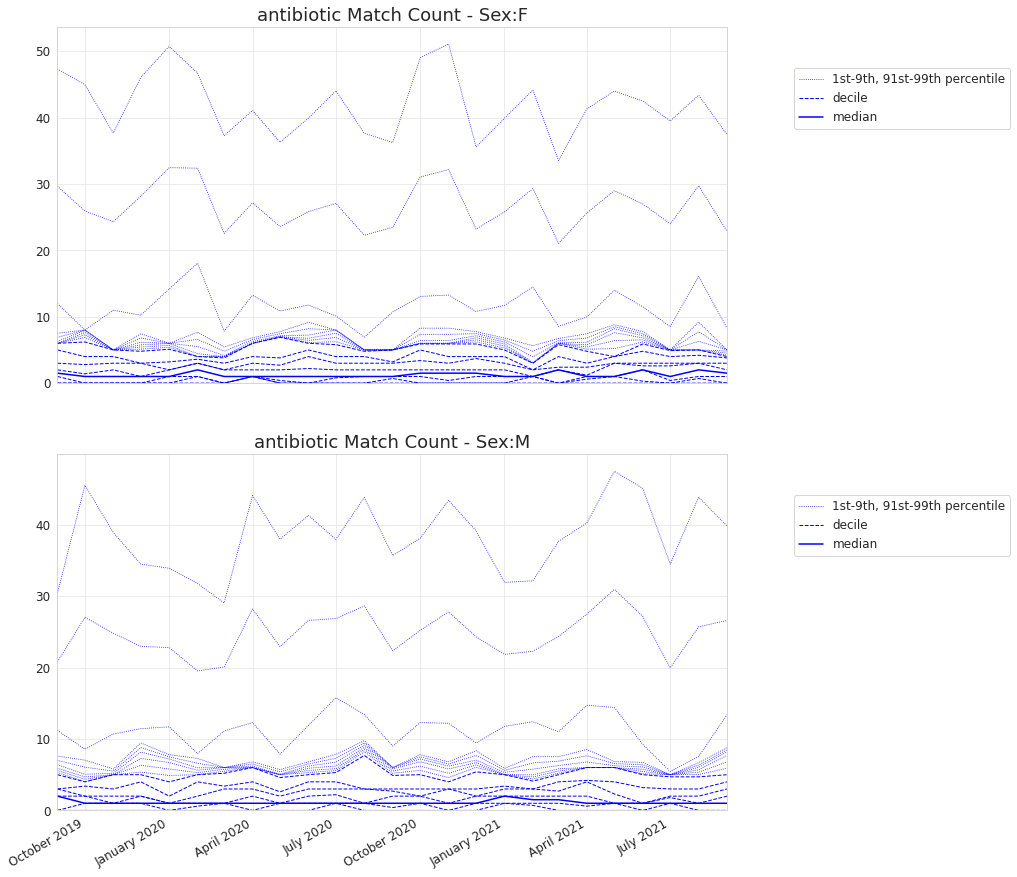

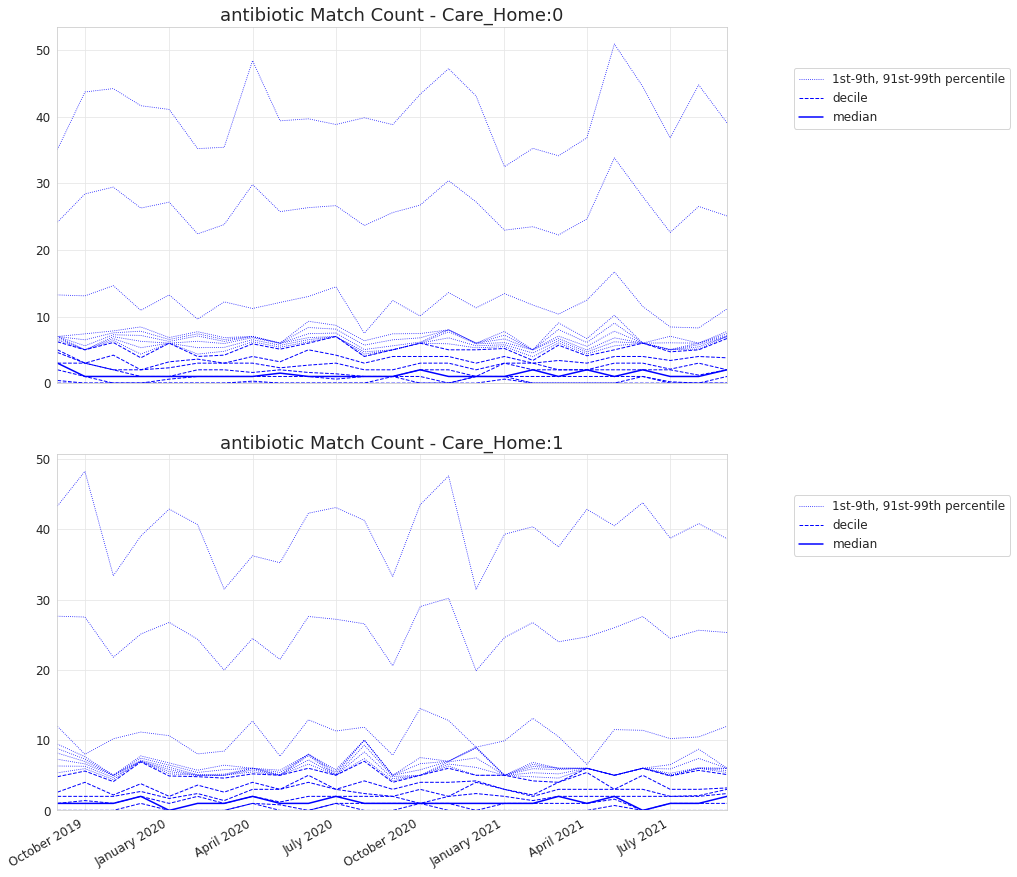

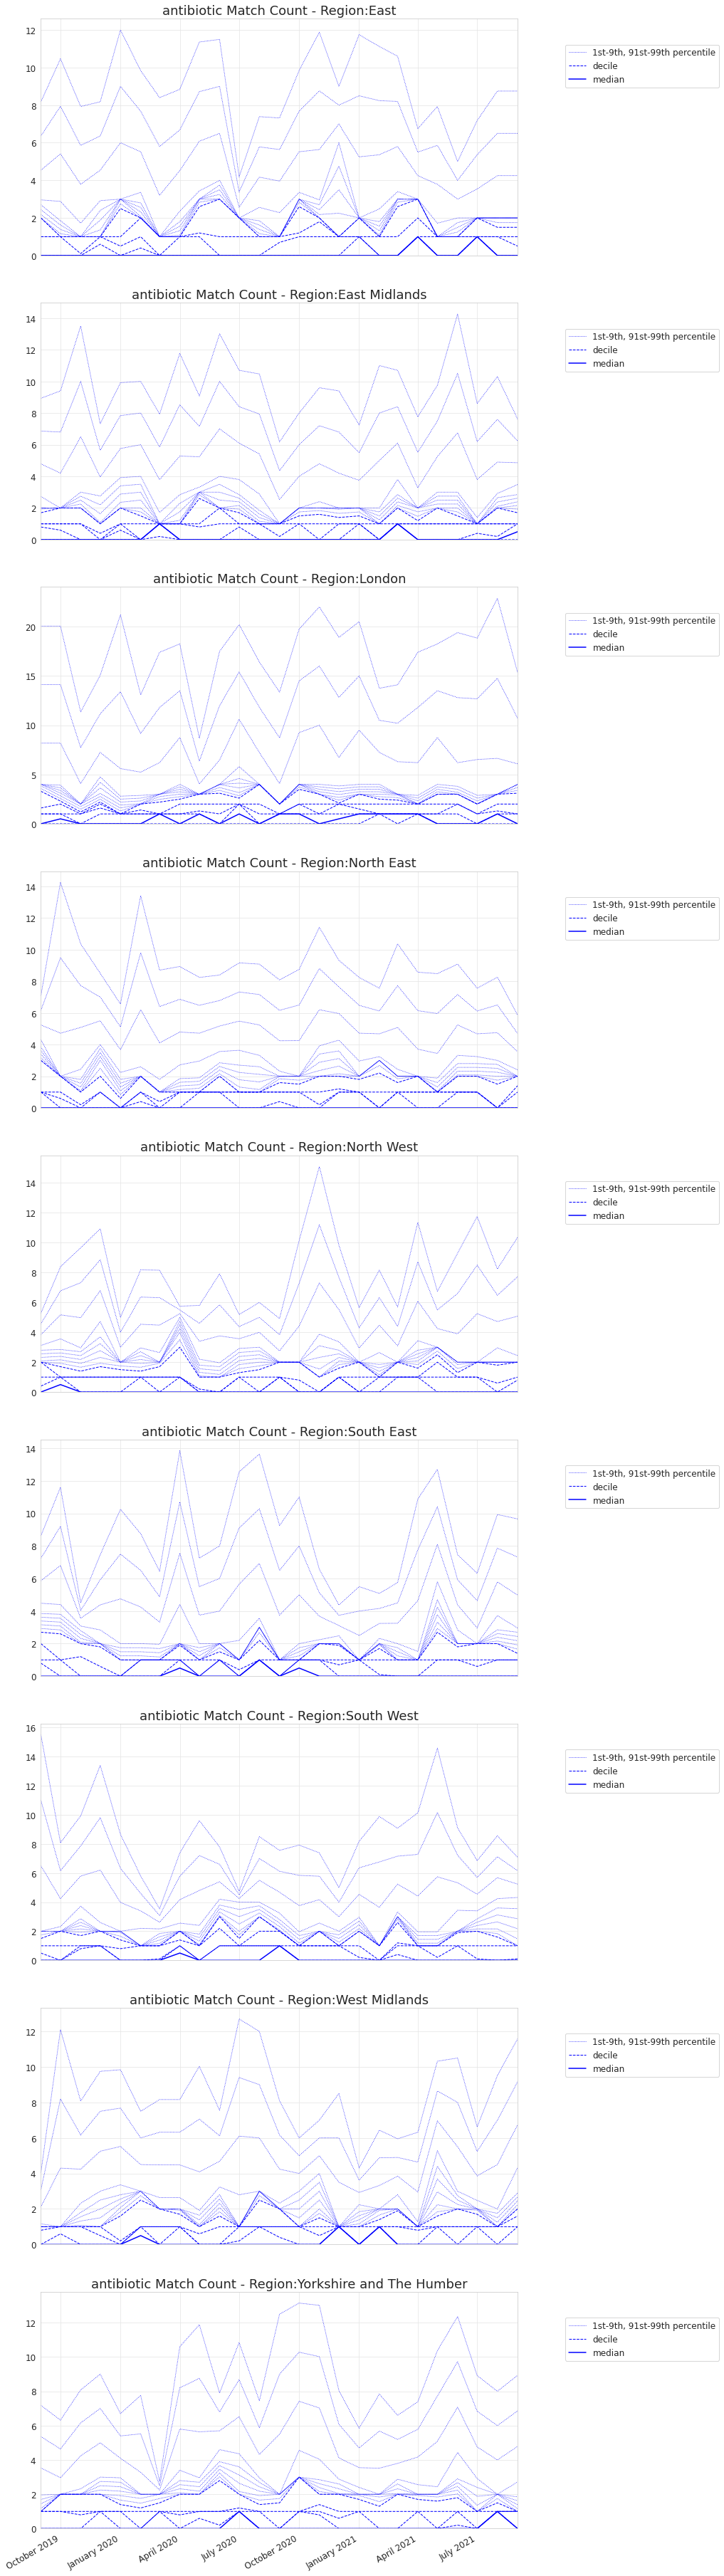

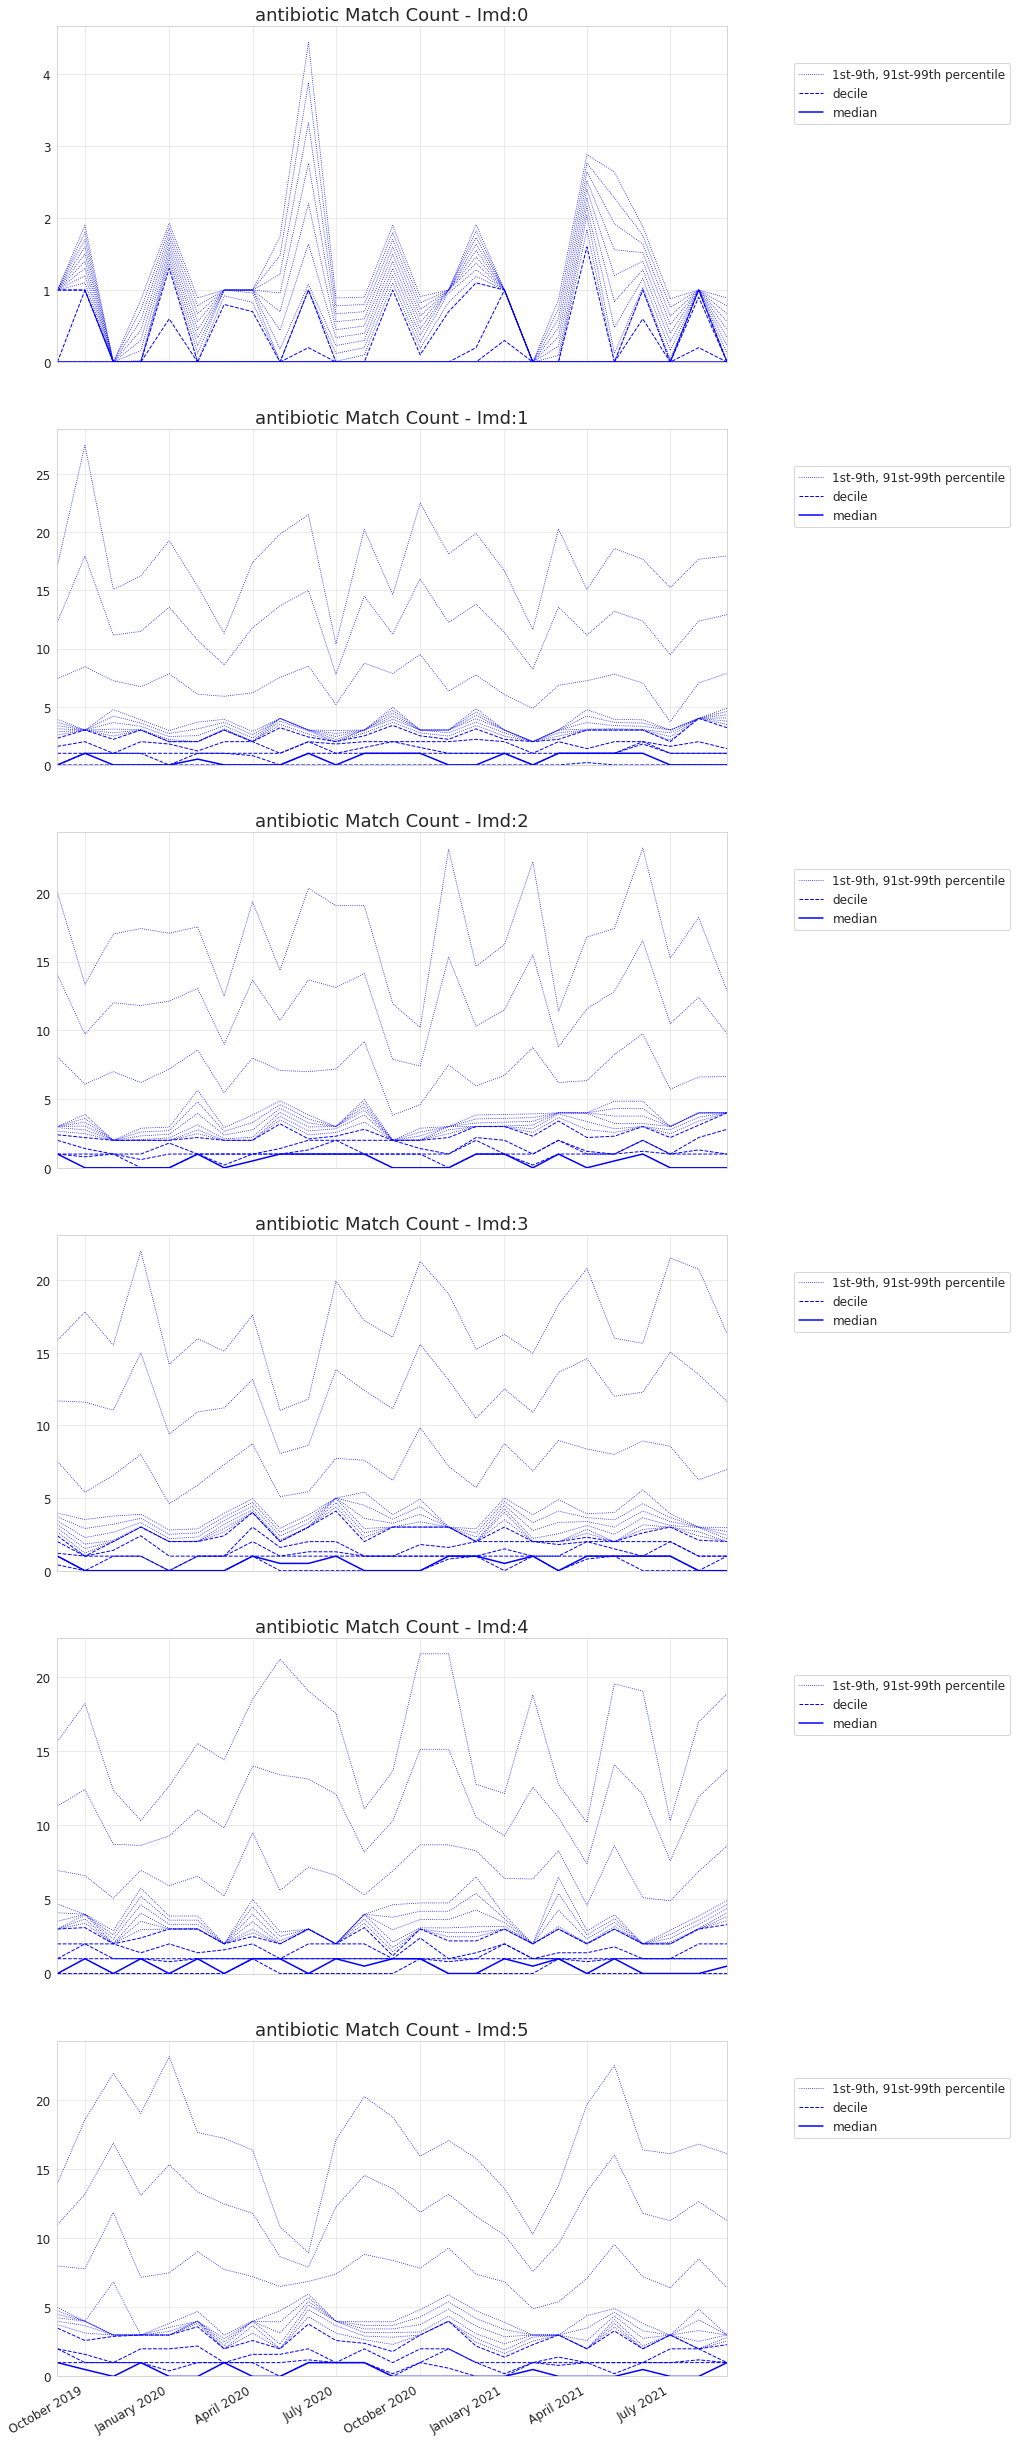

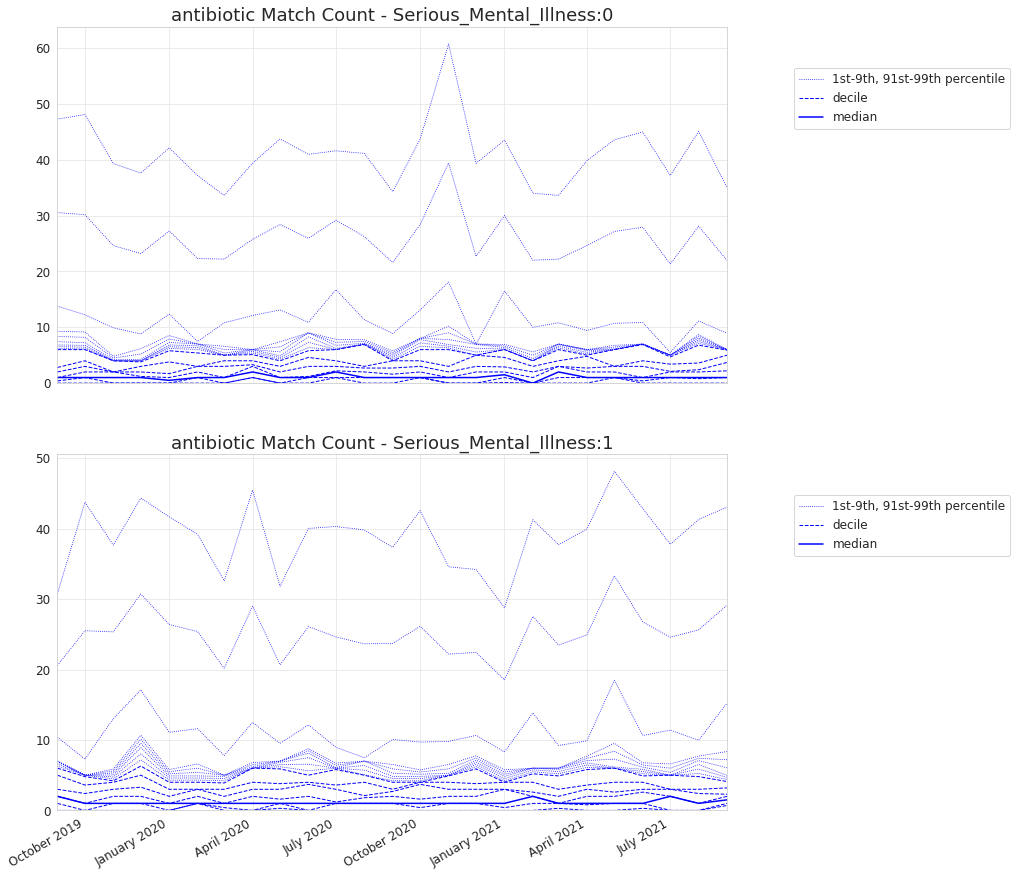

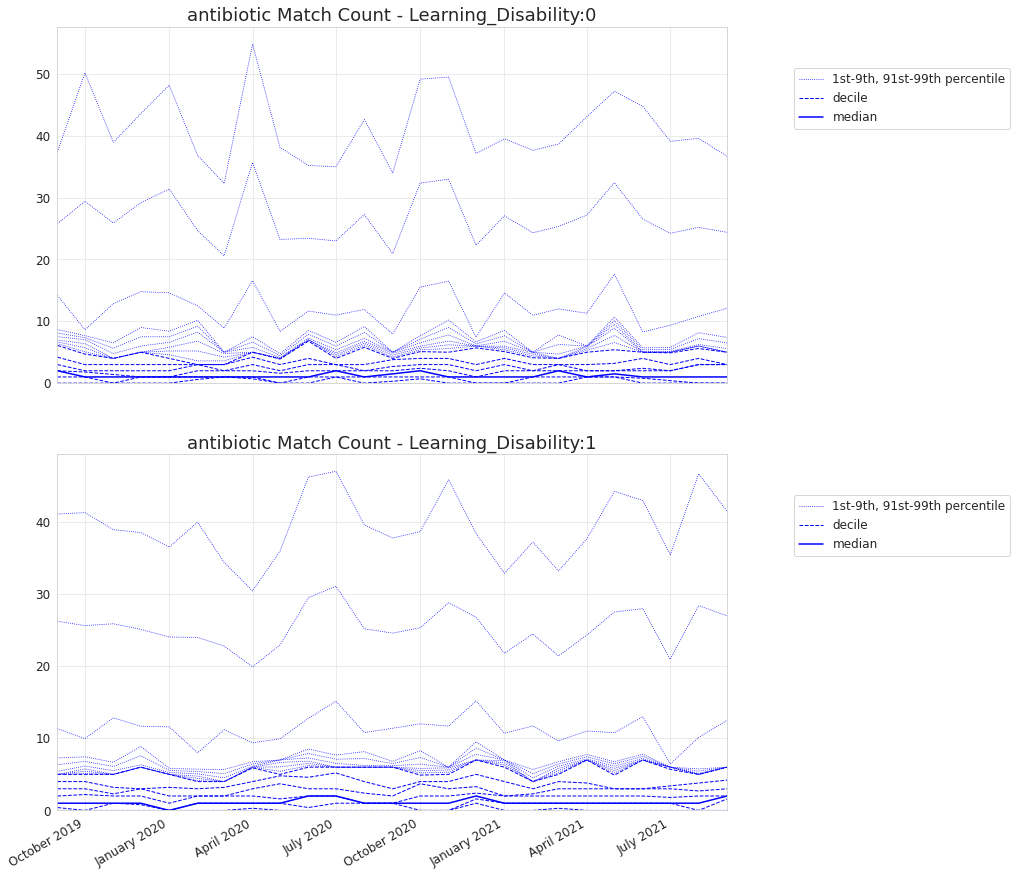

In [69]:
if "practice" in groups:
    groups.remove("practice")
plots = []
for x in ['infection','antibiotic']:
    for group in groups:
        df_to_plot = (
            df.groupby(["practice", group, "date"])[f'{x}_match_count']
            .sum()
            .reset_index()
        )
        
        group_values = df_to_plot[group].drop_duplicates()
        n_groups = len(group_values)
        fig = plt.figure(figsize=(12, 8 * n_groups))
        fig.autofmt_xdate()
        layout = gridspec.GridSpec(n_groups, 1, figure=fig)
        for groupval, lax in zip(group_values, layout):
            ax = plt.subplot(lax)
            charts.deciles_chart(
                df_to_plot[df_to_plot[group] == groupval],
                "date",
                f'{x}_match_count',
                f'{x+"_match_count".replace("_"," ").title()} - {group.title()}:{groupval}',
                ax=ax,
            )
        plots.append(fig)